## Before you start

You'll need the latest version of the  **azure-ai-ml** package to run the code in this notebook. Run the cell below to verify that it is installed.

> **Note**:
> If the **azure-ai-ml** package is not installed, run `pip install azure-ai-ml` to install it.

In [4]:
pip show azure-ai-ml

Name: azure-ai-ml
Version: 1.20.0
Summary: Microsoft Azure Machine Learning Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python
Author: Microsoft Corporation
Author-email: azuresdkengsysadmins@microsoft.com
License: MIT License
Location: /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages
Requires: azure-common, azure-core, azure-mgmt-core, azure-storage-blob, azure-storage-file-datalake, azure-storage-file-share, colorama, isodate, jsonschema, marshmallow, msrest, opencensus-ext-azure, opencensus-ext-logging, pydash, pyjwt, pyyaml, strictyaml, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## Connect to your workspace

With the required SDK packages installed, now you're ready to connect to your workspace.

To connect to a workspace, we need identifier parameters - a subscription ID, resource group name, and workspace name. Since you're working with a compute instance, managed by Azure Machine Learning, you can use the default values to connect to the workspace.

In [2]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [3]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

Found the config file in: /config.json


## Prepare data

You don't need to create a training script for automated machine learning, but you do need to load the training data. 

In this case, you'll use a dataset containing details of diabetes patients. 

To pass a dataset as an input to an automated machine learning job, the data must be in tabular form and include a target column. For the data to be interpreted as a tabular dataset, the input dataset must be a **MLTable**.

A MLTable data asset has already been created for you during set-up. You can explore the data asset by navigating to the **Data** page. You'll retrieve the data asset here by specifying its name `diabetes-training-table` and version `1`. 

In [14]:
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential

# Set the version number of the data asset (for example: '1')
VERSION = "2"

# Set the path, supported paths include:
# local: './<path>/<file>' (this will be automatically uploaded to cloud storage)
# blob:  'wasbs://<container_name>@<account_name>.blob.core.windows.net/<path>/<file>'
# ADLS gen2: 'abfss://<file_system>@<account_name>.dfs.core.windows.net/<path>/<file>'
# Datastore: 'azureml://datastores/<data_store_name>/paths/<path>/<file>'
path = "./src/data/datasets/silver/final_dataset.csv"

# Define the Data asset object
my_data = Data(
    path=path,
    type=AssetTypes.URI_FILE,
    description="list of movies",
    name="IMDb",
    version=VERSION,
)

# Create the data asset in the workspace
ml_client.data.create_or_update(my_data)





HttpResponseError: (UserError) A data version with this name and version already exists. If you are trying to create a new data version, use a different name or version. If you are trying to update an existing data version, the existing asset's data uri cannot be changed. Only tags, description, and isArchived can be updated.
Code: UserError
Message: A data version with this name and version already exists. If you are trying to create a new data version, use a different name or version. If you are trying to update an existing data version, the existing asset's data uri cannot be changed. Only tags, description, and isArchived can be updated.
Additional Information:Type: ComponentName
Info: {
    "value": "managementfrontend"
}Type: Correlation
Info: {
    "value": {
        "operation": "f6187b06f1ac9670fd457ccdeba3de65",
        "request": "45943d326ab9fec7"
    }
}Type: Environment
Info: {
    "value": "eastus"
}Type: Location
Info: {
    "value": "eastus"
}Type: Time
Info: {
    "value": "2025-02-05T12:37:24.2176323+00:00"
}Type: InnerError
Info: {
    "value": {
        "code": "Immutable",
        "innerError": {
            "code": "DataVersionPropertyImmutable",
            "innerError": null
        }
    }
}Type: MessageFormat
Info: {
    "value": "A data version with this name and version already exists. If you are trying to create a new data version, use a different name or version. If you are trying to update an existing data version, the existing asset's {property} cannot be changed. Only tags, description, and isArchived can be updated."
}Type: MessageParameters
Info: {
    "value": {
        "property": "data uri"
    }
}

In [15]:
## create data asset if it doesn't already exist:
try:
    data_asset = ml_client.data.get(name="IMDb", version=2)
    print(
        f"Data asset already exists. Name: {my_data.name}, version: {my_data.version}"
    )
except:
    ml_client.data.create_or_update(my_data)
    print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

Data asset already exists. Name: IMDb, version: 2


## Read data in notebook

Pandas directly support URIs - this example shows how to read a CSV file from an Azure Machine Learning Datastore:

In [11]:
import pandas as pd

df = pd.read_csv("azureml://subscriptions/c66db437-1a3b-4722-bfcf-a0d23758fb67/resourcegroups/rg-imdb/workspaces/mlw-imdb/datastores/workspaceblobstore/paths/LocalUpload/8d5a50e8a5bcefc12b9b40a97b62b7c7/final_dataset.csv")
df.head()

,id,Title,Movie Link,Year,Duration,MPA,Rating,Votes,budget,grossWorldWide,...,writers,stars,genres,countries_origin,filming_locations,production_companies,Languages,wins,nominations,oscars
0,tt0073195,Jaws,https://www.imdb.com/title/tt0073195,1975,2h 4m,PG,8.1,683K,7000000.0,477220580.0,...,"['Peter Benchley', 'Carl Gottlieb']","['Roy Scheider', 'Robert Shaw', 'Richard Dreyf...","['Monster Horror', 'Sea Adventure', 'Survival'...",['United States'],"[""Water Street, Edgartown, Martha's Vineyard, ...","['Zanuck/Brown Productions', 'Universal Pictur...",['English'],0,20,0
1,tt0073629,The Rocky Horror Picture Show,https://www.imdb.com/title/tt0073629,1975,1h 40m,R,7.4,173K,1200000.0,115798478.0,...,"[""Richard O'Brien"", 'Jim Sharman']","['Tim Curry', 'Susan Sarandon', 'Barry Bostwick']","['Dark Comedy', 'Raunchy Comedy', 'Rock Musica...","['United Kingdom', 'United States']","['Oakley Court, Windsor Road, Oakley Green, Wi...","['Twentieth Century Fox', 'Michael White Produ...",['English'],0,4,0
2,tt0073486,One Flew Over the Cuckoo's Nest,https://www.imdb.com/title/tt0073486,1975,2h 13m,R,8.7,1.1M,3000000.0,109115366.0,...,"['Lawrence Hauben', 'Bo Goldman', 'Ken Kesey']","['Jack Nicholson', 'Louise Fletcher', 'Michael...","['Medical Drama', 'Psychological Drama', 'Drama']",['United States'],['Oregon State Mental Hospital - 2600 Center S...,"['Fantasy Films', 'N.V. Zvaluw']",['English'],0,15,0
3,tt0072890,Dog Day Afternoon,https://www.imdb.com/title/tt0072890,1975,2h 5m,R,8.0,279K,1800000.0,50002721.0,...,"['Frank Pierson', 'P.F. Kluge', 'Thomas Moore']","['Al Pacino', 'John Cazale', 'Penelope Allen']","['Heist', 'True Crime', 'Biography', 'Crime', ...",['United States'],"['285 Prospect Park West, Brooklyn, New York C...","['Warner Bros.', 'Artists Entertainment Complex']",['English'],0,20,0
4,tt0073692,Shampoo,https://www.imdb.com/title/tt0073692,1975,1h 50m,R,6.4,15K,4000000.0,49407734.0,...,"['Robert Towne', 'Warren Beatty']","['Warren Beatty', 'Julie Christie', 'Goldie Ha...","['Satire', 'Comedy', 'Drama']",['United States'],"['2270 Bowmont Drive, Beverly Hills, Californi...","['Persky-Bright / Vista', 'Columbia Pictures',...",['English'],0,11,0


In [8]:
%pip install -U azureml-fsspec

Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd

# get a handle of the data asset and print the URI
data_asset = ml_client.data.get(name="IMDb", version=2)
print(f"Data asset URI: {data_asset.path}")

# read into pandas - note that you will see 2 headers in your data frame - that is ok, for now

df = pd.read_csv(data_asset.path)
df.head()

Data asset URI: azureml://subscriptions/c66db437-1a3b-4722-bfcf-a0d23758fb67/resourcegroups/rg-imdb/workspaces/mlw-imdb/datastores/workspaceblobstore/paths/LocalUpload/8d5a50e8a5bcefc12b9b40a97b62b7c7/final_dataset.csv


,id,Title,Movie Link,Year,Duration,MPA,Rating,Votes,budget,grossWorldWide,...,writers,stars,genres,countries_origin,filming_locations,production_companies,Languages,wins,nominations,oscars
0,tt0073195,Jaws,https://www.imdb.com/title/tt0073195,1975,2h 4m,PG,8.1,683K,7000000.0,477220580.0,...,"['Peter Benchley', 'Carl Gottlieb']","['Roy Scheider', 'Robert Shaw', 'Richard Dreyf...","['Monster Horror', 'Sea Adventure', 'Survival'...",['United States'],"[""Water Street, Edgartown, Martha's Vineyard, ...","['Zanuck/Brown Productions', 'Universal Pictur...",['English'],0,20,0
1,tt0073629,The Rocky Horror Picture Show,https://www.imdb.com/title/tt0073629,1975,1h 40m,R,7.4,173K,1200000.0,115798478.0,...,"[""Richard O'Brien"", 'Jim Sharman']","['Tim Curry', 'Susan Sarandon', 'Barry Bostwick']","['Dark Comedy', 'Raunchy Comedy', 'Rock Musica...","['United Kingdom', 'United States']","['Oakley Court, Windsor Road, Oakley Green, Wi...","['Twentieth Century Fox', 'Michael White Produ...",['English'],0,4,0
2,tt0073486,One Flew Over the Cuckoo's Nest,https://www.imdb.com/title/tt0073486,1975,2h 13m,R,8.7,1.1M,3000000.0,109115366.0,...,"['Lawrence Hauben', 'Bo Goldman', 'Ken Kesey']","['Jack Nicholson', 'Louise Fletcher', 'Michael...","['Medical Drama', 'Psychological Drama', 'Drama']",['United States'],['Oregon State Mental Hospital - 2600 Center S...,"['Fantasy Films', 'N.V. Zvaluw']",['English'],0,15,0
3,tt0072890,Dog Day Afternoon,https://www.imdb.com/title/tt0072890,1975,2h 5m,R,8.0,279K,1800000.0,50002721.0,...,"['Frank Pierson', 'P.F. Kluge', 'Thomas Moore']","['Al Pacino', 'John Cazale', 'Penelope Allen']","['Heist', 'True Crime', 'Biography', 'Crime', ...",['United States'],"['285 Prospect Park West, Brooklyn, New York C...","['Warner Bros.', 'Artists Entertainment Complex']",['English'],0,20,0
4,tt0073692,Shampoo,https://www.imdb.com/title/tt0073692,1975,1h 50m,R,6.4,15K,4000000.0,49407734.0,...,"['Robert Towne', 'Warren Beatty']","['Warren Beatty', 'Julie Christie', 'Goldie Ha...","['Satire', 'Comedy', 'Drama']",['United States'],"['2270 Bowmont Drive, Beverly Hills, Californi...","['Persky-Bright / Vista', 'Columbia Pictures',...",['English'],0,11,0


## Play with data
Use PCA, T-SNE and UMAP to have a better understanding of the data

### Preprocess the Data

Ensure the data is clean and numerical:

In [37]:
import pandas as pd
import pylab as pl
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing

# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Handle missing values (if any)
numeric_df = numeric_df.dropna()

# normalize data

data_scaled = pd.DataFrame(preprocessing.scale(numeric_df),columns = numeric_df.columns) 


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [39]:
numeric_df.head()
print(data_scaled.columns)

Index(['Year', 'Rating', 'budget', 'grossWorldWide', 'gross_US_Canada',
       'opening_weekend_Gross', 'wins', 'nominations', 'oscars'],
      dtype='object')


#### PCA

A linear dimensionality reduction technique that transforms data into new axes (principal components) based on variance. It identifies directions (components) where the data varies the most, making it useful for reducing features while preserving global structure.

          Year    Rating    budget  grossWorldWide  gross_US_Canada  \
PC-1  0.134943  0.192457  0.002238        0.530982         0.533307   
PC-2 -0.144241  0.556157  0.005103       -0.176882        -0.162741   

      opening_weekend_Gross  wins  nominations    oscars  
PC-1               0.504845  -0.0     0.310148  0.165309  
PC-2              -0.280489  -0.0     0.450393  0.574943  


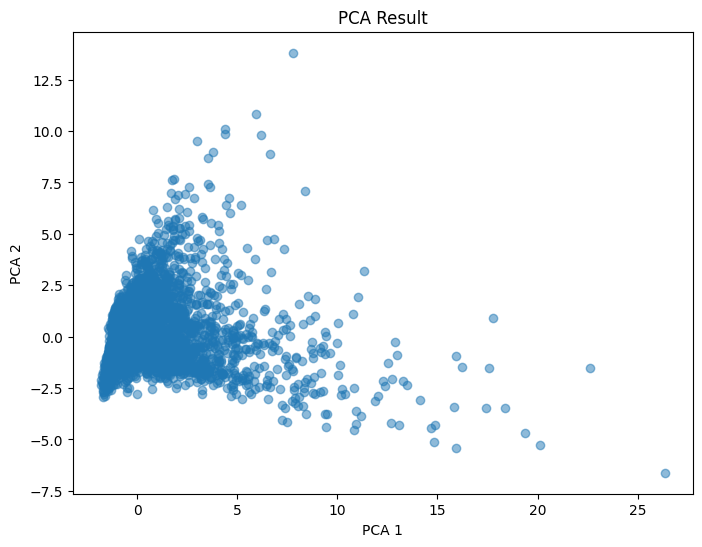

In [40]:

import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

print(pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2']))


# Visualize PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Result')
plt.show()

#### t-SNE (t-Distributed Stochastic Neighbor Embedding)

The core idea behind t-SNE is to map high-dimensional data points to a lower-dimensional space, typically two or three dimensions, in a way that preserves the local relationships between points. It achieves this by measuring the similarity between data points in the high-dimensional space and representing this similarity as probabilities. Then, it constructs a similar probability distribution in the lower-dimensional space and minimizes the difference between the two distributions using a technique called gradient descent. This process allows t-SNE to effectively capture the local structure of the data, making it particularly useful for visualizing complex datasets and discovering meaningful patterns.

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


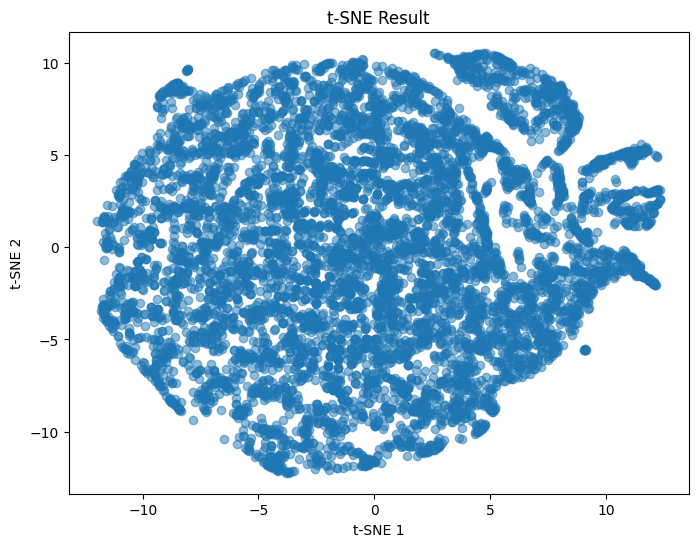

In [41]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(scaled_data)

# Visualize t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Result')
plt.show()

#### UMAP (Uniform Manifold Approximation and Projection)

A non-linear dimensionality reduction method that preserves both local and global data structures. It’s faster than t-SNE and handles large datasets well, making it great for visualization and clustering tasks.

2025-02-05 12:41:50.198130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-05 12:41:51.231547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-05 12:41:51.524736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 12:41:53.714434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-05 12:41:58.378468: W tensorflow/comp

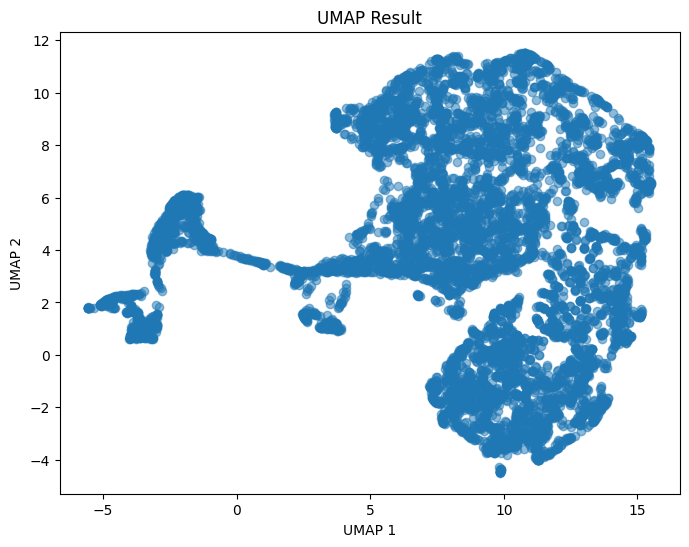

In [24]:
import umap

# Apply UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
umap_result = umap_model.fit_transform(scaled_data)

# Visualize UMAP
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Result')
plt.show()

## Use data in a job

After using a notebook for experimentation. You can use scripts to train machine learning models. A script can be run as a job, and for each job you can specify inputs and outputs. 

You can use either **data assets** or **datastore paths** as inputs or outputs of a job. 

The cells below creates the **move-data.py** script in the **src** folder. The script reads the input data with the `read_csv()` function. The script then stores the data as a CSV file in the output path.

In [ ]:
%%writefile $script_folder/move-data.py
# import libraries
import argparse
import pandas as pd
import numpy as np
from pathlib import Path

def main(args):
    # read data
    df = get_data(args.input_data)

    output_df = df.to_csv((Path(args.output_datastore) / "diabetes.csv"), index = False)

# function that reads the data
def get_data(path):
    df = pd.read_csv(path)

    # Count the rows and print the result
    row_count = (len(df))
    print('Analyzing {} rows of data'.format(row_count))
    
    return df

def parse_args():
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--input_data", dest='input_data',
                        type=str)
    parser.add_argument("--output_datastore", dest='output_datastore',
                        type=str)

    # parse args
    args = parser.parse_args()

    # return args
    return args

# run script
if __name__ == "__main__":
    # add space in logs
    print("\n\n")
    print("*" * 60)

    # parse args
    args = parse_args()

    # run main function
    main(args)

    # add space in logs
    print("*" * 60)
    print("\n\n")


In [ ]:
from azure.ai.ml import Input, Output
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import command

# configure input and output
my_job_inputs = {
    "local_data": Input(type=AssetTypes.URI_FILE, path="azureml:diabetes-local:1")
}

my_job_outputs = {
    "datastore_data": Output(type=AssetTypes.URI_FOLDER, path="azureml://datastores/blob_training_data/paths/datastore-path")
}

# configure job
job = command(
    code="./src",
    command="python move-data.py --input_data ${{inputs.local_data}} --output_datastore ${{outputs.datastore_data}}",
    inputs=my_job_inputs,
    outputs=my_job_outputs,
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
    compute="aml-cluster",
    display_name="move-diabetes-data",
    experiment_name="move-diabetes-data"
)

# submit job
returned_job = ml_client.create_or_update(job)
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

## Configure automated machine learning job

Now, you're ready to configure the automated machine learning experiment.

When you run the code below, it will create an automated machine learning job that:

- Uses the compute cluster named `aml-cluster`
- Sets `Diabetic` as the target column
- Sets `accuracy` as the primary metric
- Times out after `60` minutes of total training time 
- Trains a maximum of `5` models
- No model will be trained with the `LogisticRegression` algorithm

In [ ]:
from azure.ai.ml import automl

# configure the classification job
classification_job = automl.classification(
    compute="XX",
    experiment_name="XX",
    training_data=my_training_data_input,
    target_column_name="CCOLUMN",
    primary_metric="accuracy",
    n_cross_validations=5,
    enable_model_explainability=True
)

# set the limits (optional)
classification_job.set_limits(
    timeout_minutes=60, 
    trial_timeout_minutes=20, 
    max_trials=5,
    enable_early_termination=True,
)

# set the training properties (optional)
classification_job.set_training(
    blocked_training_algorithms=["LogisticRegression"], 
    enable_onnx_compatible_models=True
)

## Run an automated machine learning job

OK, you're ready to go. Let's run the automated machine learning experiment.

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    classification_job
)  

# submit the job to the backend
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)